In [2]:
%load_ext autoreload
%autoreload 2
import waffles
import numpy as np
import json
import shutil 
from tqdm import tqdm

from waffles.input_output.hdf5_structured import load_structured_waveformset
from waffles.data_classes.Waveform import Waveform
from waffles.data_classes.WaveformSet import WaveformSet
from waffles.data_classes.BasicWfAna import BasicWfAna
from waffles.data_classes.IPDict import IPDict
from waffles.data_classes.UniqueChannel import UniqueChannel
from waffles.data_classes.ChannelWsGrid import ChannelWsGrid
from waffles.utils.baseline.baseline import SBaseline
from waffles.np02_utils.AutoMap import generate_ChannelMap, dict_uniqch_to_module, dict_module_to_uniqch, ordered_channels_membrane, ordered_modules_membrane, strUch
from waffles.np02_utils.PlotUtils import np02_gen_grids, plot_grid, plot_detectors, genhist, fithist, runBasicWfAnaNP02, runBasicWfAnaNP02Updating

In [28]:
dettype = "membrane"
# runs = [
#         38785,
#         38786,
#         38787,
#         38789,
#         38790,
#         38792,
#         38794,
#         38796,
#         38798,
# ]
runs = [
    38926,
    38928
]
detectors = ["M5(1)"]
channels = [ uch.channel for m, uch in dict_module_to_uniqch.items() if m in detectors ]

## Only change if necessary
datadir = f"/eos/experiment/neutplatform/protodune/experiments/ProtoDUNE-VD/commissioning/"
det = "VD_Cathode_PDS" if dettype == "cathode" else "VD_Membrane_PDS"
endpoint = 106 if dettype == "cathode" else 107


In [29]:
from glob import glob
import copy
def open_processed(run, dettype, output_dir, channels = None, endpoints=None, nwaveforms=None, mergefiles = True, verbose=True):
    """
    Open the processed waveform set for a given run and detector type.
    """
    try: 
        wfset = load_structured_waveformset(
            f"{output_dir}/processed/run{run:0d}_{dettype}/processed_merged_run{run:06d}_structured_{dettype}.hdf5",
            max_to_load=nwaveforms,
            channels_filter=channels,
            endpoint_filter=endpoints
        )
    except:
        files = glob(f"{output_dir}/processed/run{run:06d}_{dettype}/processed_*_run{run:06d}_*_{dettype}.hdf5")
        if verbose:
            print("List of files found:")
            print(files)
        if not mergefiles or len(files)==1:
            files = files[0]
            wfset = load_structured_waveformset(files, max_to_load=nwaveforms, channels_filter=channels, endpoint_filter=endpoints, verbose=verbose)
        else: 
            wfset = load_structured_waveformset(files[0], max_to_load=nwaveforms, channels_filter= channels, endpoint_filter=endpoints, verbose=verbose)
            for f in files[1:]:
                tmpwf = load_structured_waveformset(f, max_to_load=nwaveforms, channels_filter= channels, endpoint_filter=endpoints, verbose=verbose)
                wfset.merge(copy.deepcopy(tmpwf))
    return wfset

In [30]:
from collections import Counter
import copy
import time
def remove_weird_signals(waveform: Waveform) -> bool:
    if np.any((waveform.adcs[0:500] > 16000) | (waveform.adcs[0:500] < 100) ):
        return False
    return True
def create_wfset(runs, endpoint, channels):

    nwaveforms = None
    wfset_full = {}
    wfsetsub = {}
    for run in runs:
        wfset = open_processed(run, dettype, datadir, channels, [endpoint], nwaveforms=nwaveforms, verbose=True)
        wfset = WaveformSet.from_filtered_WaveformSet(wfset, remove_weird_signals, show_progress=True)
        # timestamps = sorted([ wf.timestamp for wf in wfset_full.waveforms ])
        # c = Counter(timestamps)
        # print(f"Total number of timestamps: {len(c)}")
        # matchtimestamps = [ k for k in c if c[k] >= 15]
        # print(f"Remaining timestamps: {len(matchtimestamps)}")
        
        wfset_full[run] = copy.deepcopy(wfset)
        wfsetsub[run] = WaveformSet(*wfset_full[run].waveforms[:5000])
    return wfset_full, wfsetsub
    
start = time.time()
wfset_full, wfsetsub = create_wfset(runs, endpoint, channels)
end = time.time()
print(end - start)

List of files found:
['/eos/experiment/neutplatform/protodune/experiments/ProtoDUNE-VD/commissioning//processed/run038926_membrane/processed_np02vd_raw_run038926_0000_df-s04-d0_dw_0_20250820T175354.hdf5.copied_structured_membrane.hdf5', '/eos/experiment/neutplatform/protodune/experiments/ProtoDUNE-VD/commissioning//processed/run038926_membrane/processed_np02vd_raw_run038926_0001_df-s04-d0_dw_0_20250820T175430.hdf5.copied_structured_membrane.hdf5']
📤 load_structured_waveformset returning type: <class 'waffles.data_classes.WaveformSet.WaveformSet'> with 43349 waveforms
📤 load_structured_waveformset returning type: <class 'waffles.data_classes.WaveformSet.WaveformSet'> with 21414 waveforms


100%|███████████████████████████████████████████████████████████████████████████| 64763/64763 [00:00<00:00, 85993.90it/s]


List of files found:
['/eos/experiment/neutplatform/protodune/experiments/ProtoDUNE-VD/commissioning//processed/run038928_membrane/processed_np02vd_raw_run038928_0000_df-s04-d0_dw_0_20250820T175656.hdf5.copied_structured_membrane.hdf5', '/eos/experiment/neutplatform/protodune/experiments/ProtoDUNE-VD/commissioning//processed/run038928_membrane/processed_np02vd_raw_run038928_0001_df-s04-d0_dw_0_20250820T175732.hdf5.copied_structured_membrane.hdf5']
📤 load_structured_waveformset returning type: <class 'waffles.data_classes.WaveformSet.WaveformSet'> with 43490 waveforms
📤 load_structured_waveformset returning type: <class 'waffles.data_classes.WaveformSet.WaveformSet'> with 28199 waveforms


100%|███████████████████████████████████████████████████████████████████████████| 71689/71689 [00:00<00:00, 81895.70it/s]


19.505568981170654


In [31]:
# def get_external(waveform: Waveform, validtimes = []) -> bool:
#     if np.any((waveform.adcs[0:500] > 16000) | (waveform.adcs[0:500] < 100) ):
#         return False
#     if waveform.timestamp in validtimes:
#         return True
#     return False

# wfset_full = WaveformSet.from_filtered_WaveformSet(wfset_full, get_external, matchtimestamps, show_progress=True)

In [32]:
argsheat = dict(
    mode="heatmap",
    analysis_label="std",
    adc_range_above_baseline=800,
    adc_range_below_baseline=-200,
    adc_bins=200,
    time_bins=wfset_full[runs[0]].points_per_wf//2,
    filtering=36,
    share_y_scale=False,
    share_x_scale=True,
    wfs_per_axes=5000,
    zlog=True,
    width=1000,
    height=800,
    yannotation=1.05,
)
for run in runs:
    print(run) #Because heatmaps don't have it ... 
    runBasicWfAnaNP02Updating(wfsetsub[run], updatethreshold=True, show_progress=False, configyaml="ch_trim_parameters.yaml")
    plot_detectors(wfsetsub[run], detectors, **argsheat)

38926


38928


Processing waveform set with BasicWfAna


100%|████████████████████████████████████████████████████████████████████████████| 64745/64745 [00:11<00:00, 5870.14it/s]
/eos/home-h/hvieirad/waffles/fddaq-v4.4.7-a9/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/eos/home-h/hvieirad/waffles/fddaq-v4.4.7-a9/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning:

invalid value encountered in scalar divide



Could not fit for M8(1)


/eos/home-h/hvieirad/waffles/waffles/src/waffles/utils/fit_peaks/fit_peaks_utils.py:143: RuntimeWarning:

invalid value encountered in divide



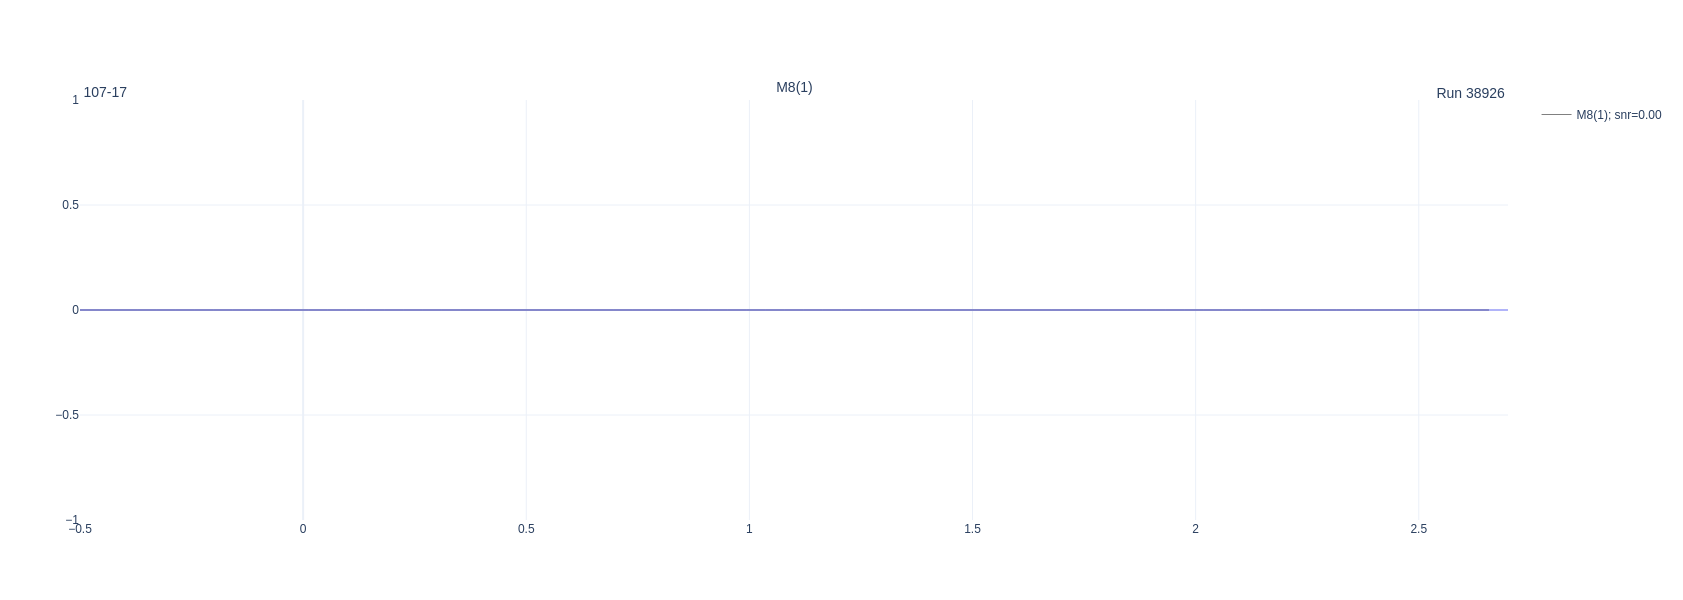

Processing waveform set with BasicWfAna


100%|████████████████████████████████████████████████████████████████████████████| 71598/71598 [00:11<00:00, 6327.67it/s]
/eos/home-h/hvieirad/waffles/fddaq-v4.4.7-a9/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/eos/home-h/hvieirad/waffles/fddaq-v4.4.7-a9/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning:

invalid value encountered in scalar divide



Could not fit for M8(1)


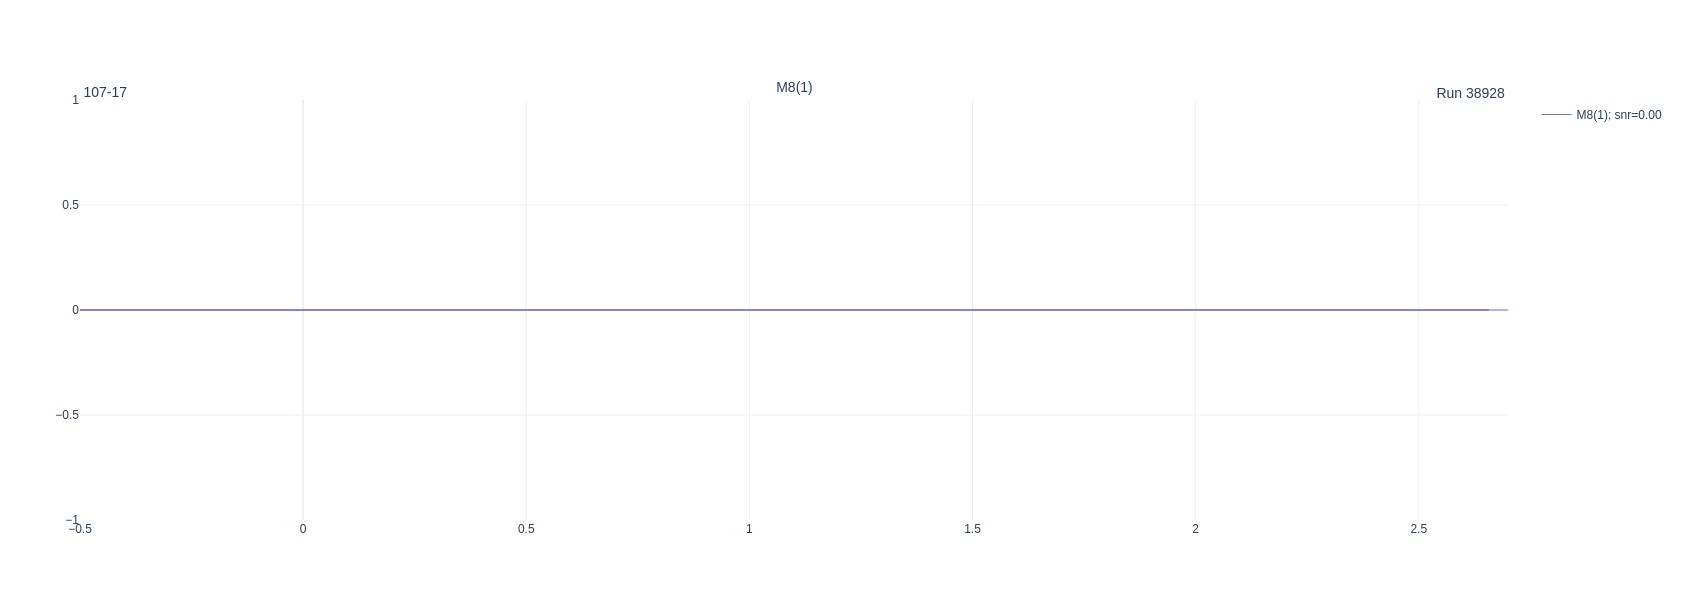

In [16]:
from pathlib import Path
from datetime import datetime 

histargs = dict(    
    # doprocess = False,
    dofit = True,
    show_progress = True,
    normalize_hist = True,
    configyaml = "ch_trim_parameters.yaml",
    update_threshold = True,
    fitmultigauss = True,
    verbosefitmultigauss = True,
)
setupargs=dict(
    width=750,
    height=600,
    showplots=True,
    yannotation=1.05,
)
htmlname = None

for run in runs:
    # if run not in [38798]:
    #     continue
    # mname = detectors[0].replace('(',"_ch").replace(")","")
    # htmlname = Path(f"./trim_{mname}_run{run:06d}.html")
    plot_detectors(wfset_full[run], detectors, plot_function=fithist, html=htmlname, wf_func=histargs, **setupargs)

In [63]:
for run in runs:
    try:
        normalization = wfset_full[run].waveforms[0].analyses['std'].result['normalization']
        gain = normalization*wfset_full[run].waveforms[0].analyses['std'].result['gain']
        errgain = normalization*wfset_full[run].waveforms[0].analyses['std'].result['errgain']
        snr = wfset_full[run].waveforms[0].analyses['std'].result['snr']
        print(f"{run}, {snr:.2f}, {gain:.2f}, {errgain:.2f}")
    except:
        pass
        

38785, 5.55, 42737.28, 632.59
38786, 5.33, 39686.30, 625.05
38787, 5.16, 36299.46, 623.61
38789, 4.37, 32278.76, 602.21
38790, 4.07, 28437.55, 635.15
38792, 4.47, 26681.64, 1048.91
38794, 3.36, 16574.62, 1107.03
38796, 1.36, 3362.23, 321.33
